In [15]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm

from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D
from keras.layers import BatchNormalization, MaxPooling2D, Flatten

In [5]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")

In [6]:
#With rescaling
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [7]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1604, 75, 75, 3)
Y shape is:(1604,)


# Transfer learning using VGG19 

In [8]:
SIZE = 75

# Split data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
# Normalize and reshape
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train / 255
X_test = X_test / 255

In [10]:
# One hot encoding
y_train_one_hot = to_categorical(Y_train)
y_test_one_hot = to_categorical(Y_test)

In [11]:
# Load VGG model
vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

In [12]:
# Make Loaded layers as non-trainable
for layer in vgg_model.layers:
    layer.trainable = False
    
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [13]:
# Now we want to use features from convolutional network (vgg16) for random forest model
feature_vgg19 = vgg_model.predict(X_train)
features = feature_vgg19.reshape(feature_vgg19.shape[0], -1)

# features extracted from vgg model is going to be X for SVM model
X_SVM = features

## SVM Model

In [17]:
C = 1.0

#model = svm.SVC(kernel='linear', C=C).fit(X_SVM, Y_train)
#model = svm.SVC(kernel='poly', C=C).fit(X_train, y_train)
model = svm.SVC(kernel='rbf', C=C).fit(X_train, y_train)
X_test_features = vgg_model.predict(X_test)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Predict the model
y_pred = model.predict(X_test_features)
print("Accuracy:",accuracy_score(Y_test, y_pred))

Accuracy: 0.48909657320872274


In [18]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       157
           1       0.00      0.00      0.00       164

    accuracy                           0.49       321
   macro avg       0.24      0.50      0.33       321
weighted avg       0.24      0.49      0.32       321



C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The prediction for this image is:  0
The actual label for this image is:  0


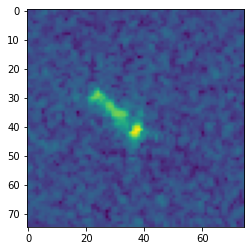

In [28]:
#Check results on a few select images
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img[:,:,0])
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=vgg_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
y_pred = model.predict(input_img_features)[0] 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[n])